# Inference of time-dependent heat flux (latent and sensible) and temperature distribution in building material using Kalman filter technique
 

In reality, we aim to detect or control an unsteady process using only __indirect measurements__ of the variables of interest. The Kalman filter method is a __real-time data assimilation technique__ that requires __sequential processing__. This means that each measurement must be processed as soon as it is obtained.

__Method__

We utilize non-intrusive temperature measurements along one boundary, which is a common method for obtaining measurement data. A thermally insulated boundary condition is applied to the left boundary, while a fixed temperature boundary condition is assumed for the right side of the plate. Discretization is performed using the implicit finite volume method. The boundary conditions are integrated into the first and last interior nodes.

__Geometry__

In this study, we consider an isotropic, one-dimensional flat plate with uniform thickness. The left boundary is thermally insulated, resulting in zero heat flux. The initial temperature throughout the plate is uniform, set at 200 degrees. We assume a linear problem without any nonlinearities stemming from the temperature dependence of thermal diffusivity. The inverse problem focuses on estimating the heat flux at the first interior node adjacent to the left boundary. Temperature measurements are taken at this node.


TWe (first 5): [28.71262 28.70289 28.69373 28.68519 28.67715]
QW (first 5): [3.10493 3.01162 3.06469 3.18609 3.34   ]
qW (first 5): [44.29375 44.12884 43.96478 43.8016  43.63929]
Tindoor (first 5): [25.85 25.85 25.85 25.85 25.85]
Radiation (first 5): [-37.62759 -37.62826 -37.63021 -37.63318 -37.637  ]


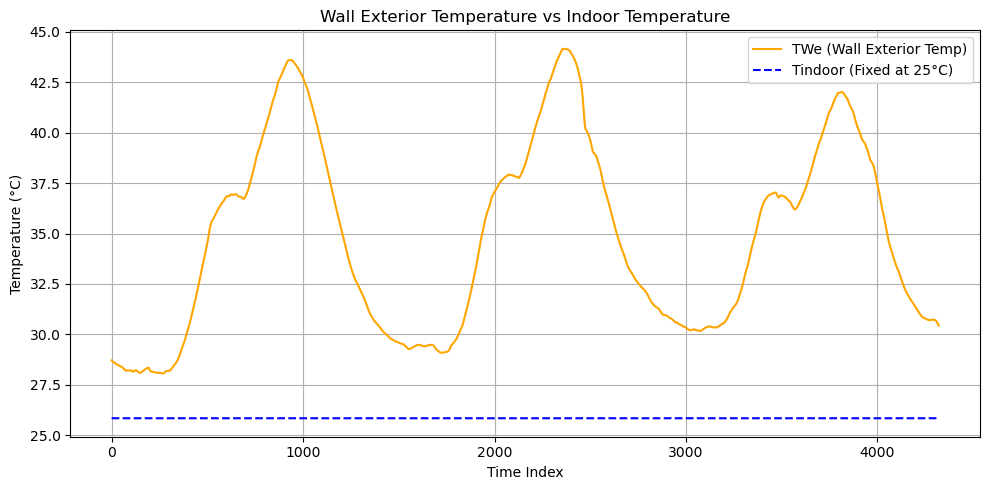

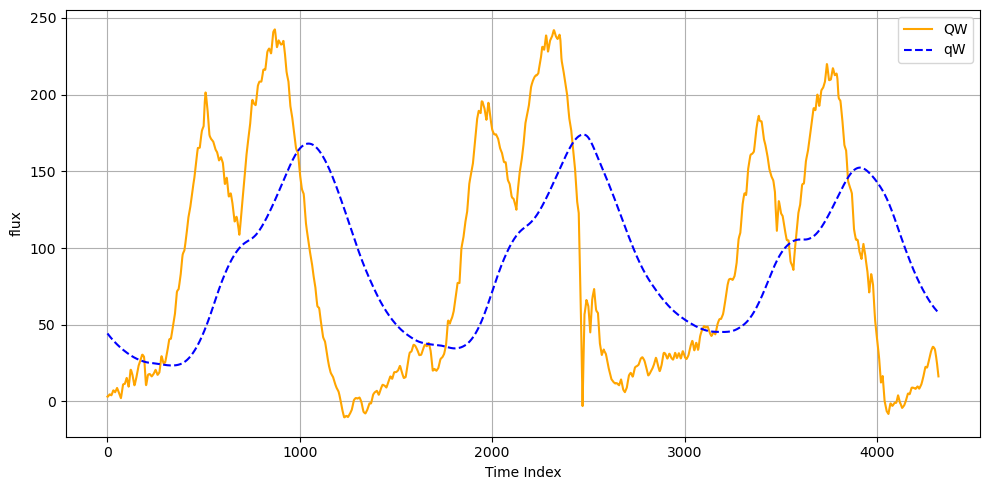

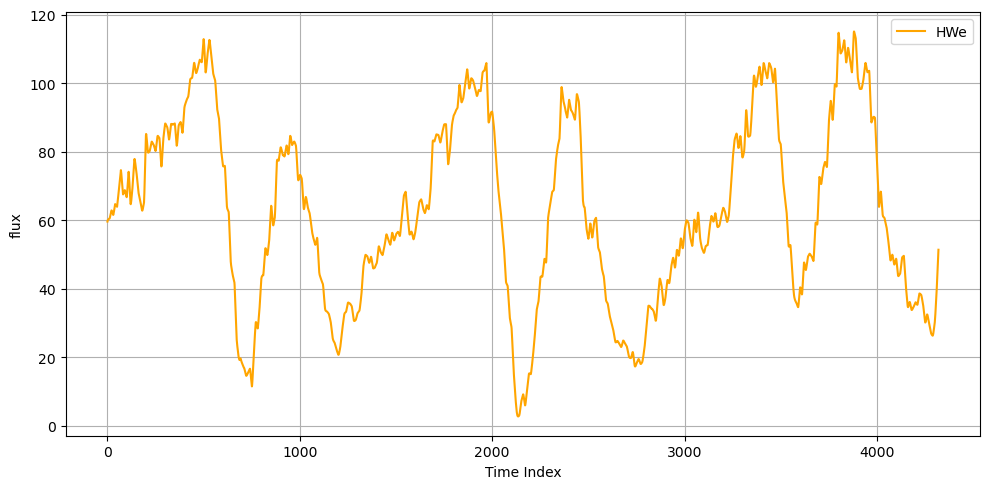

In [84]:

import numpy as np
import matplotlib.pyplot as plt

# 读取 output 文件（假设是 CSV 或空格分隔的文本文件）
# 请替换 'output.txt' 为你的实际文件路径
output = np.loadtxt('PUCM_clear_days_AH_sine.txt')

time_skip=60  #dt=time_skip*AH_data['dt']

# 提取所需变量（列索引从 0 开始）
TWe = output[:, 14]   # 第15列
QW = output[:, 21]    # 第22列
qW = output[:, 22]    # 第23列
SWe = output[:, 6]    # 第7列
LWe = output[:, 7]    # 第8列
HWe = output[:,8]

# 生成 indoor 温度数组
Tindoor = np.full_like(TWe, 25.85)  # 与 TWe 相同长度，值为25
#AH_true = np.full_like(TWe[0:60*24*3], 100)
AH_true2 = 100 + 50 * np.sin(2 * np.pi * np.arange(60 * 24 * 3) / 60 / 24)

# 计算辐射 radiation
radiation = SWe + LWe

# 简单输出检查
print(f'TWe (first 5): {TWe[:5]}')
print(f'QW (first 5): {QW[:5]}')
print(f'qW (first 5): {qW[:5]}')
print(f'Tindoor (first 5): {Tindoor[:5]}')
print(f'Radiation (first 5): {radiation[:5]}')

# 可视化（例如画出 TWe 和 Tindoor 对比）
plt.figure(figsize=(10, 5))
plt.plot(TWe, label='TWe (Wall Exterior Temp)', color='orange')
plt.plot(Tindoor, label='Tindoor (Fixed at 25°C)', linestyle='--', color='blue')
plt.xlabel('Time Index')
plt.ylabel('Temperature (°C)')
plt.title('Wall Exterior Temperature vs Indoor Temperature')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(QW, label='QW', color='orange')
plt.plot(qW, label='qW', linestyle='--', color='blue')
plt.xlabel('Time Index')
plt.ylabel('flux')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(HWe, label='HWe', color='orange')
plt.xlabel('Time Index')
plt.ylabel('flux')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

[0.    0.002 0.006 0.01  0.014 0.018 0.022 0.026 0.03  0.034 0.038 0.042
 0.046 0.05  0.054 0.058 0.062 0.066 0.07  0.074 0.078 0.082 0.086 0.09
 0.094 0.098 0.102 0.106 0.11  0.114 0.118 0.122 0.126 0.13  0.134 0.138
 0.142 0.146 0.15  0.154 0.158 0.162 0.166 0.17  0.174 0.178 0.182 0.186
 0.19  0.194 0.198 0.2  ]
73


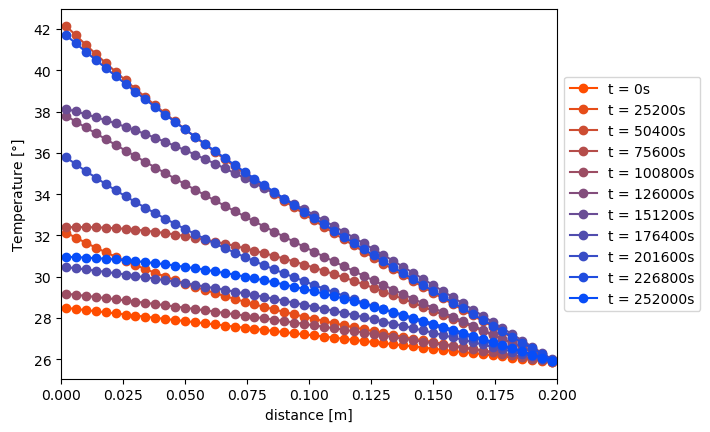

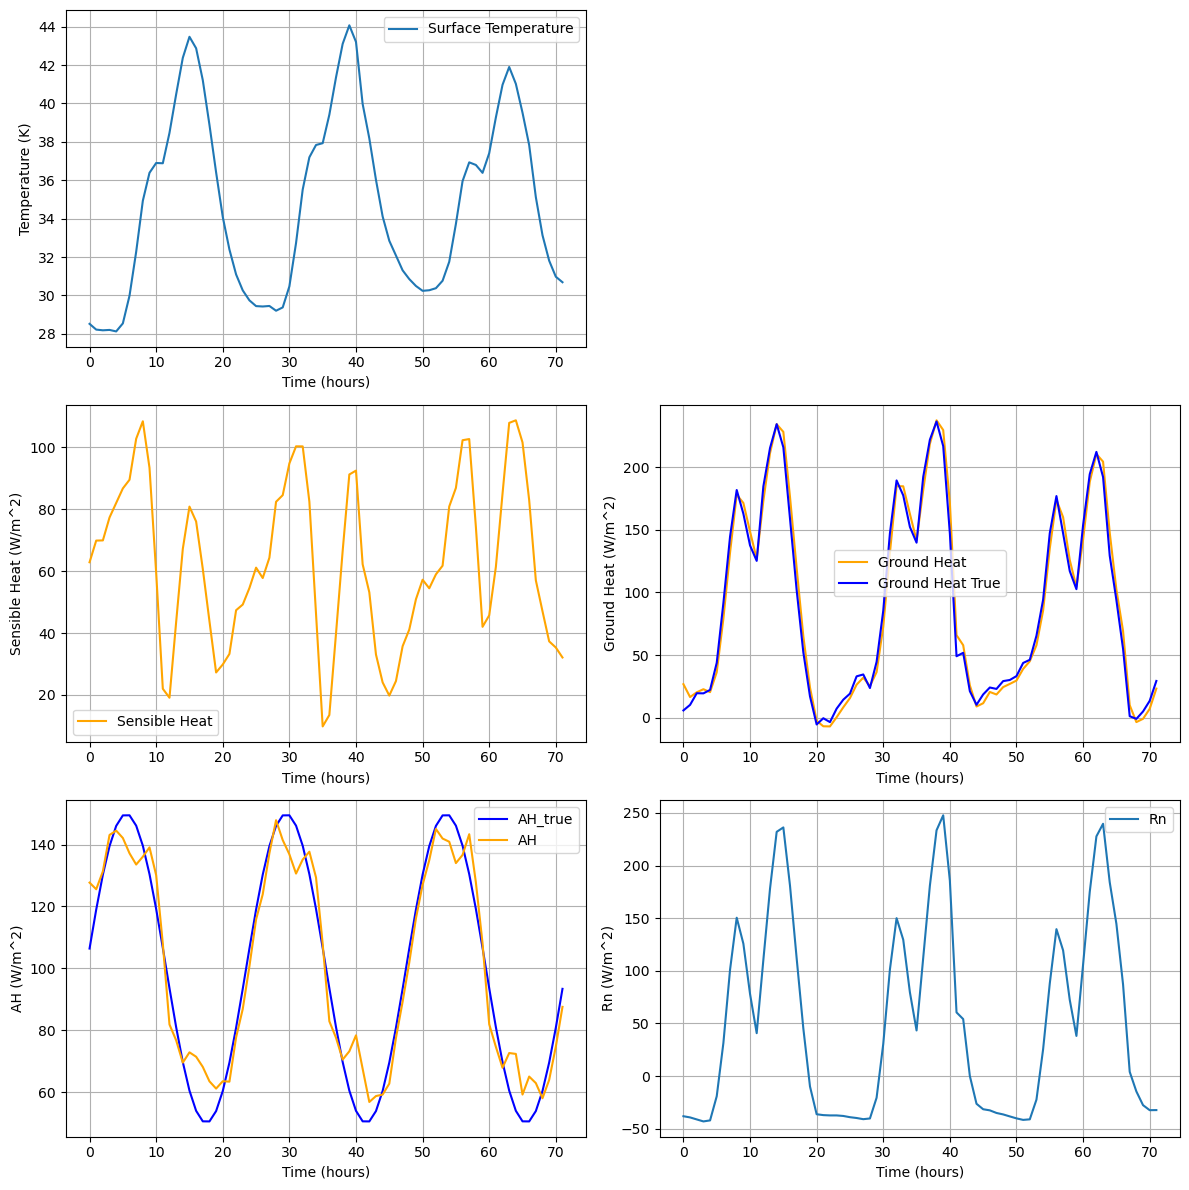

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import math

#Define the problem

N         = 50 # Number of Grid Points
L         = 0.2 #plate length (meter)
dx        = L/N #control volume length (uniform)

x=np.zeros(N+2)# x coordinates
x[0]=0
x[-1]=L
for i in range(N):
     x[i+1]= i*dx+dx/2
print(x)

Time      = 3600*24*3 #total time in (second)
dt        = 60*time_skip #time step (second)

#flux_frequency=0.5*np.pi/Time
#flux_magnitude=10

k         = 2 #(W/mK) #dividing by 100 for simplification
rhoc      = 2.112*10**6 #(J/m3K)  #dividing by 100 for simplification

#value of coefficients
k_dx      = (k/dx) 
rhocdx_dt = (rhoc*dx/dt)
#T_B       = 300 #Temperature on the far right side

apo       = rhocdx_dt #apo doesn't vary with x or t hence constant


# 参数设置
rho_air = 1.225  # 空气密度 (kg/m^3)
cp_air = 1005  # 空气比热容 (J/(kg·K))
k_air = 1.2  # 热导率 (W/(m·K))
h_a = 10  # 空气层厚度 (m)
z_om = 0.01 #m
z_oh=z_om/10
d=0      #displacement height
kappa=0.4
ustar=1 #m/s

# 初始条件
#T_s_initial = 295  # 初始表面温度 (K)
#T_a_initial = 295  # 初始空气温度 (K)
#R_n = 200  # 初始辐射通量 (W/m^2)



#node 1
aw_l   = 0 
ae_l   = k_dx
Sp_l   = -2*k_dx
Su_l   = 0
ap_l   = aw_l + ae_l + apo - Sp_l

#node 2 to N-1
aw_in  = k_dx
ae_in  = k_dx
Sp_in  = 0
Su_in  = 0
ap_in  = aw_in + ae_in + apo - Sp_in

#node N
aw_r   = k_dx
ae_r   = 0
Sp_r   = -2*k_dx
Su_r   = 0
ap_r   = aw_r + ae_r + apo - Sp_r

num_interior_cvs = int(L/dx)

# Initialize coefficient matrix and right-hand side vector
#A*T=b(T^0)+f
A = np.zeros((num_interior_cvs, num_interior_cvs))
b = np.zeros(num_interior_cvs)
f = np.zeros((num_interior_cvs,1))

#Interior node on the far left affected by the left boundary condition
A[0,0] = ap_l
A[0,1] = -ae_l

#Interior node on the far right affected by the right boundary condition
A[N-1,N-2] = -aw_r
A[N-1,N-1] = ap_r
        
# Define the coefficients matrix A using control volume method
for i in range(1, num_interior_cvs):
    if 1 <= i <= num_interior_cvs - 2:
        #Interior nodes
        A[i, i] = ap_in  # Coefficient for the central node
        A[i, i - 1] = -aw_in  # Coefficient for the left node
        A[i, i + 1] = -ae_in  # Coefficient for the right node
    #elif i == num_interior_cvs - 1: #also correct but put BCs together for clarification
    #    #Interior node on the far right affected by the right boundary condition
    #    A[i,i-1] = -aw_r
    #    A[i,i] = ap_r

#print(A)
# Number of iterations
num_iterations = int(Time/dt) # every iteration means an incremental dt 

# Total time steps
t = np.arange(0, dt+num_iterations*dt, dt)

# Initialize an empty matrix to store the results
T_stack = np.empty((0, N))

#T_LST(t)=T_LST_0+temp_magnitude*(t/Time)
#T_left_0=T_s_initial
#T_left = T_left_0*np.ones(num_iterations)
#temp_magnitude_left=10
#T_a=T_a_initial*np.ones(num_iterations)
#T_a_magnitude=5

#T_right_0=299
#T_right = T_right_0*np.ones(num_iterations)
#temp_magnitude_right=0

# 定义函数计算每 time_skip 个数的平均值，处理最后不足 time_skip 的情况
def average_over_time_skip(data, time_skip):
    n = len(data)
    remainder = n % time_skip
    if remainder != 0:
        data = data[:n - remainder]  # 忽略最后不足 time_skip 的元素
    data = data.reshape(-1, time_skip)
    return np.mean(data, axis=1)


T_left = average_over_time_skip(TWe[0:-1], time_skip)
T_right = average_over_time_skip(Tindoor[0:-1], time_skip)
# T_can = average_over_time_skip(Tcan[0:-1], time_skip)
H_sensible = average_over_time_skip(HWe[0:-1], time_skip)
R_n = average_over_time_skip(SWe[0:-1] + LWe[0:-1], time_skip)
G_ground_true = average_over_time_skip(QW[0:-1], time_skip)
AH_true = average_over_time_skip(AH_true2, time_skip)

T_left_0=T_left[0]
T_right_0=T_right[0]
# iteratively update the T values at the 5 iterior nodes
f[[0]]=Su_l
f[[N-1]]=Su_r

for i in range(1, num_interior_cvs-1):
    f[[i]]=Su_in

#print(f)


#initial condition
Tinit = Tinit = np.linspace(T_left[0]+(T_right[0]-T_left[0])/(2*N), T_right[0]-(T_right[0]-T_left[0])/(2*N), N).reshape(N, 1)
#print(Tinit)

shape = (N,1) #5 corresponds to 5 cvs or interior nodes

#Iteratively solving x/T via Ax = b 
b = np.full(shape,apo*Tinit) # initialize b

# Iterate to update b and solve for x
T = np.full(shape,Tinit) # initialize T

#H_sensible=np.zeros(num_iterations)
G_ground=np.zeros(num_iterations)
AH=np.zeros(num_iterations)

for i in range(num_iterations):
     #print(i)
     #print(apo*T)
     #f[[1]]=flux_magnitude*np.sin(flux_frequency*(i*dt))
     #r_a=math.log((h_a-d)/z_om)*math.log((h_a-d)/z_oh)/(kappa**2*ustar)
     #H_sensible[i]=rho_air*cp_air*(T_left[i]-T_a[i])/r_a

     #T_a[i]=T_a_initial+T_a_magnitude*(i*dt/Time)
     #T_left[i]=T_left_0+temp_magnitude_left*(i*dt/Time)
     #T_right[i]=T_right_0+temp_magnitude_right*(i*dt/Time)
     #print(i,T_right[i])
     f[[0]]=2*k_dx*T_left[i]
     f[[-1]]=2*k_dx*T_right[i]
     b = np.full((N,1),apo*T)
     T = np.linalg.solve(A, b+f)
     G_ground[i]=-k*(T[0,0]-T_left[i])/(dx/2)
     #H_sensible[i]=rho_air*cp_air*(T_left[i]-T_a[i])/r_a

     AH[i]=H_sensible[i]+G_ground[i]-R_n[i]
     #T_a[i+1]=T_a[i] + dt * H_sensible[i] / (rho_air * cp_air * h_a)
     #T_a[i]=T_left[i]-H_sensible[i]/(rho_air*cp_air)*r_a
     #print(r_a,G_ground[i],H_sensible[i],AH[i])
     T_stack = np.vstack((T_stack, T.T))  # Store T data into a single matrix Transpose to make it 1 by 5
     #print(T_stack[i,-2],T_stack[i,-1],1.5*T_stack[i,-1]-0.5*T_stack[i,-2])


#text = f"At time: {t[-1]} (Iteration#: {num_iterations}), the corresponding Temperature is: {T}"
#print(text)
#print(A)
#print(T.shape)


m = len(t)
print(m)
R = np.linspace(1,0,m)
B = np.linspace(0,1,m)
G = 0.3

time_intervel=int(m/10)

for j in range(0,m-1,time_intervel):
    plt.plot(x[1:-1], T_stack[j,:], color = [R[j],G,B[j]], marker='o')
plt.legend([f't = {dt*value}s' for value in range(0, m, time_intervel)], loc='center left', bbox_to_anchor=(1, 0.5))

plt.xlabel('distance [m]')
plt.ylabel(r'Temperature [$\degree$]')

# Set new limits for the x and y axes
plt.xlim([0, L])  # Set x-axis limits from 0 to 0.02
#plt.ylim([0, 200])   # Set y-axis limits from 0 to 200

#save_path = '/Users/minghan/OneDrive - Cornell University/JupyterNotes/Data_Assimilation/HeatFluxInference_KF/implicit_all.pdf'
#plt.savefig(save_path,format='pdf', dpi=300, bbox_inches='tight')

time_series = np.arange(0, Time, dt)
plt.figure(figsize=(12, 12))
plt.subplot(3, 2, 1)
plt.plot(time_series / 3600, T_left, label='Surface Temperature')
plt.xlabel('Time (hours)')
plt.ylabel('Temperature (K)')
plt.legend()
plt.grid(True)


plt.subplot(3, 2, 3)
plt.plot(time_series / 3600, H_sensible, label='Sensible Heat', color='orange')
plt.xlabel('Time (hours)')
plt.ylabel('Sensible Heat (W/m^2)')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 4)
plt.plot(time_series / 3600, G_ground, label='Ground Heat', color='orange')
plt.plot(time_series / 3600, G_ground_true, label='Ground Heat True', color='blue')
plt.xlabel('Time (hours)')
plt.ylabel('Ground Heat (W/m^2)')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 5)
plt.plot(time_series / 3600, AH_true, label='AH_true', color='blue')
plt.plot(time_series / 3600, AH, label='AH', color='orange')
plt.xlabel('Time (hours)')
plt.ylabel('AH (W/m^2)')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 6)
plt.plot(time_series / 3600, R_n, label='Rn')
#plt.plot(time_series / 3600, Rs[0:int(Time/dt)], label='Rs')
plt.xlabel('Time (hours)')
plt.ylabel('Rn (W/m^2)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

compare to the exact 

The nonintrusive synthetic data obtained at the boundary

We desire the product of $a_{P}^{o}T_{P}^{o}$. To express this in matrix notation, we need to represent $a_{P}^{\circ}$ as a diagonal matrix, as shown below:

$S_{u}$ is the deterministic component of the source term $b$, such as the convectional heat transfer coefficient, radiation heat flux, and incident radiative. Values of $S_u$ can be grouped to construct the matrix $C$

### Matrices for discretized algebraic equations


In [86]:
# Create a 5x5 diagonal matrix with diagonal elements set to 200
#A_big*x=M*x^0+C

M = np.diag([apo] * N + [1] * 2)

print("N:", N)
print("apo:", apo)
print("Diagonal Matrix:")
print(M)


#node 1
aw_l   = 0 
ae_l   = k_dx
Sp_l   = 0
Su_l   = 0
ap_l   = aw_l + ae_l + apo - Sp_l

#node 2 to N-1
aw_in  = k_dx
ae_in  = k_dx
Sp_in  = 0
Su_in  = 0
ap_in  = aw_in + ae_in + apo - Sp_in

#node N
aw_r   = k_dx
ae_r   = 0
Sp_r   = 0
Su_r   = 0
ap_r   = aw_r + ae_r + apo - Sp_r

# Initialize coefficient matrix and right-hand side vector
#A*T=b(T^0)+f
A = np.zeros((num_interior_cvs, num_interior_cvs))

#Interior node on the far left affected by the left boundary condition
A[0,0] = ap_l
A[0,1] = -ae_l

#Interior node on the far right affected by the right boundary condition
A[N-1,N-2] = -aw_r
A[N-1,N-1] = ap_r
        
# Define the coefficients matrix A using control volume method
for i in range(1, num_interior_cvs):
    if 1 <= i <= num_interior_cvs - 2:
        #Interior nodes
        A[i, i] = ap_in  # Coefficient for the central node
        A[i, i - 1] = -aw_in  # Coefficient for the left node
        A[i, i + 1] = -ae_in  # Coefficient for the right node

A_big = np.zeros((num_interior_cvs+2, num_interior_cvs+2))
A_big[0:-2,0:-2]=A
A_big[-2,-2]=1
A_big[-1,-1]=1
A_big[0,-2]=-1
A_big[-3,-1]=1

# A^{-1}
phi = np.linalg.inv(A_big)@M
phi.shape
print(A,A_big,phi)


C = np.zeros((N, 1))
A_inv = np.linalg.inv(A)
# U^{*}
U_star = A_inv @ C

# Combine the matrix U_star with 0 based on column 
U = np.concatenate((U_star, np.zeros_like(U_star[:1]),np.zeros_like(U_star[:1])),axis=0) 

#print(U)

# Augmented measurement matrix H^{*}

#H = np.array([[1, 0, 0, 0, 0, 0]])
#H = np.array([[0, 0, 0, 0, 1, 0]])

H=np.zeros((2,N+2))



H[0,0]=1
#H[0,1]=-1/3
H[0,-2]=0.5/k_dx
H[1,-3]=1
#H[1,-4]=-1/3
H[1,-1]=-0.5/k_dx
print(H,H.shape)

N: 50
apo: 2.3466666666666667
Diagonal Matrix:
[[2.34666667 0.         0.         ... 0.         0.         0.        ]
 [0.         2.34666667 0.         ... 0.         0.         0.        ]
 [0.         0.         2.34666667 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 2.34666667 0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]
[[ 502.34666667 -500.            0.         ...    0.
     0.            0.        ]
 [-500.         1002.34666667 -500.         ...    0.
     0.            0.        ]
 [   0.         -500.         1002.34666667 ...    0.
     0.            0.        ]
 ...
 [   0.            0.            0.         ... 1002.34666667
  -500.            0.        ]
 [   0.            0.            0.         ... -500.
  1002.34666667 -500.        ]
 [   0.            0.            0.         ...    0.
  -500.          

### Measurement matrix
The measurement matrix is characterized by $\mathbf z$, the measurement mean, and $\mathbf R$, the measurement covariance. 



#### Measurement function $H$

We need to design $\mathbf H$ so that $\mathbf{H\bar X}$ yields a measurement. For this problem we have one sensor that measures position, so $\mathbf z$ will be a __one variable vector__:

$$\mathbf{H}=\begin{bmatrix}1&0&0&0&0&0\end{bmatrix}$$

### State vector

#### Naming

$X$ is the state vector. $\mathbf{X}$ is the __standard name for state vector__ in Kalman filter! Please try to avoid using other names for the state vector. 

#### Augmented state

In this particular problem, we have two state variables: 

1. temperature

2. west boundary heat flux

_Temperature_ is the __observed variable__ - directly measured by a sensor, and _west boundary heat flux_ is the __hidden variable__ - inferred from the observed variable (Temperature).

#### State covariance

The augmented state vector $X$ has its corresponding covariance matrix $\mathbf{P}$. __We specify an initial value for $\mathbf P$ and the filter updates it during each epoch.__

Note that the variances of individual variables are found along the diagonal of the covariance matrix, while the covariances are located in the off-diagonal elements. 

As we don't know how boundary heat flux $q(t)$ and internal temperature are correlated, let's __initialize__ the covariances to zero. __Kalman filter__ will computes this for us. Of course, if you know the covariances you should use them.


#### Covariance matrix P

noise matrix

#### Measurement z

_The industry standard for platinum RTD's according to IEC-751 is + /- 0.12% (of resistance) at 0°C, commonly referred to as Class B accuracy. This will provide an accuracy of + /- 0.3°C at 0°C, which is quite good if you compare it to the __+ /- 2.2°C of a standard Type J or K thermocouple__. But as the temperature increases, so does the permissible deviation due to the variations possible in the TC. So, not only do we have the possible + /- .3°C offset at 0°C, but also the probability that the TC is not equal to 0.00385. This could account for a permissible deviation of up to __+ /- 4.6°C at a maximum temperature of 850°C__._

1. Let's be conservative and choose the type with a maximum error of + /- 4.6°C. That means we have a standard deviation of approximately __1.53°C__, resulting in a corresponding variance of about __$2.35°C^2$__.

2. Let's choose the more accurate Class-B sensor with a maximum error of + /- 0.3°C at 0°C. The standard deviation is approximately $0.1°C^2$ , resulting in a corresponding variance of about $0.01°C^2$. 

(72,) (72,)


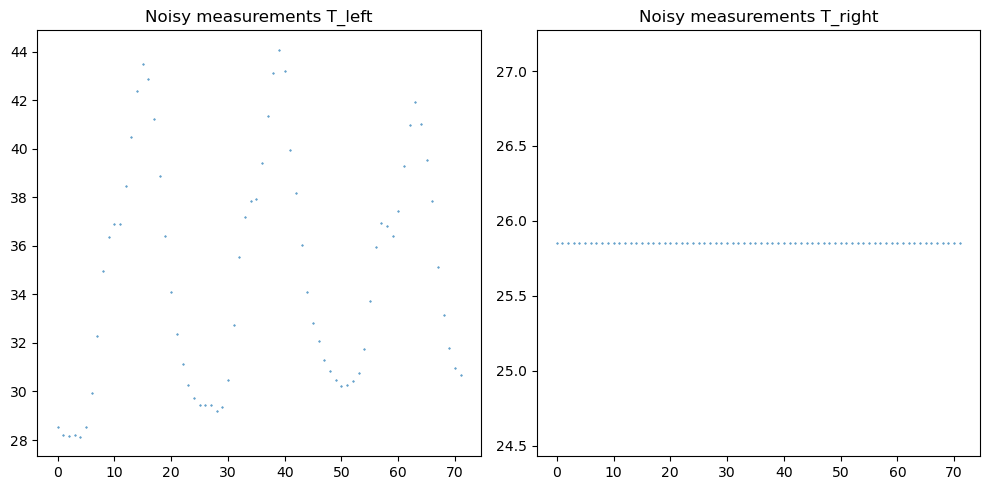

In [93]:
import math
#R_var = 100
#R_var = 2.35
mean_step=1 #mean_step average LST  not used, always =1, replaced by time_skip
R_var1 = 0.01/time_skip
R_var2 = R_var1
mu=0  #mu degree overestimate LST
R = np.array([[R_var1,0], [0,R_var2]])
z_std1 = math.sqrt(R_var1)
z_std2 = math.sqrt(R_var2)
zs1 = []
zs2 = []

T_left1 = np.zeros(len(T_left))
T_left2 = np.zeros(len(T_left) // mean_step)

T_right1 = np.zeros(len(T_right))
T_right2 = np.zeros(len(T_right) // mean_step)

for i in range(len(T_stack[:,0])):
    T_left1[i]=T_left[i] + np.random.randn() * z_std1 +mu
    T_right1[i]=T_right[i]

for i in range(len(T_left2)):
    start_index = i * mean_step
    end_index = start_index + mean_step
    T_left2[i] = np.mean(T_left1[start_index:end_index])
    zs1.append(T_left2[i])
    #zs2.append(T_right[i] + np.random.randn() * z_std2)
    #zs1.append(T_left[i] )
    T_right2[i] = np.mean(T_right1[start_index:end_index])
    zs2.append(T_right2[i] )
zs1 = np.array(zs1)
zs2 = np.array(zs2)

zs = np.vstack((zs1, zs2))

#print(zs1,zs2)
print(zs1.shape,zs2.shape)

# 创建一个包含两个子图的图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# 左边子图
ax1.plot(zs1, marker='o', linestyle='', fillstyle='none', markersize=0.5)
ax1.set_title("Noisy measurements T_left")

# 右边子图
ax2.plot(zs2, marker='o', linestyle='', fillstyle='none', markersize=0.5)
ax2.set_title("Noisy measurements T_right")

# 显示图形
plt.tight_layout()
plt.show()

#### Set initial conditions
We need to set the variances to __reasonable values__. For example, we may choose $\sigma_\mathtt{T}^2=4444 K^2$ if we are __quite uncertain__ about the initial temperature. As the insulated boundary condition is assumed at the left side, the maximum temperature should be $200 K$. Let $3\sigma_\mathtt{T} = 200 K$, then $\sigma_\mathtt{T}^2 = (\frac{200}{3} K)^2 = 4444 K^{2}$. __While let's assume we are certain about the guessed initial temperature, and we can give small covariance values for temperature, e.g., $\sigma_{T}^2 = 100 K^2$.__ As we can notice that $100 K^2$ is small compared to $4444 K^2$. Max heat flux for this situation is around, say, $q = 10 W/m^2$, so in the absence of any other information about the heat flux we can set $3\sigma_\mathtt{q}=10 W/m^2$, or $\sigma_\mathtt{q}^2=(\frac{10}{3})^2=11.11$.

1. About __68%__ of the data falls within $1\sigma$ of the mean.
2. About __95%__ falls within $2\sigma$.
3. About __99.7%__ falls within $3\sigma$.

In [94]:

#Q = np.diag([0,0,0,0,0,0.1])
Q_temp_node=R_var1
Q_flux_node=900

#Q = np.diag([Q_1st_left_node,0,0,0,0,0]) #process noise covariance
Q = np.diag([Q_temp_node] * N+[Q_flux_node]*2)

print(Q)

#indices = np.where(Q == Q_temp_node)
#row_index, col_index = indices

estimate_flux_mean1=-k*(T_right_0-T_left_0)/L
estimate_flux_mean2=-k*(T_right_0-T_left_0)/L
estimate_flux_var=Q_flux_node

#x = np.array([[200], [200], [200], [200], [200],[10]])
x = np.concatenate((Tinit, np.array(estimate_flux_mean1).reshape(1,1),np.array(estimate_flux_mean2).reshape(1,1))).reshape(-1, 1)
print(x)



#diagonal_elements = [0, 0, 0, 0, 0, 1000]
diagonal_elements = np.zeros(N+2)
diagonal_elements[-1]=estimate_flux_var
diagonal_elements[-2]=estimate_flux_var
P = np.diag(diagonal_elements)

print(P)

# store the initial P
P_init = diagonal_elements 
x_init = x
#print(x,x_init,Q)


from scipy.linalg import inv
import math
import numpy as np
import matplotlib.pyplot as plt
#from kf_book.mkf_internal import plot_track
#x = np.concatenate((np.repeat(200, N), [10])).reshape(-1, 1)
#print(x,x.shape,x_init,U,phi,P,Q)
#print(zs.shape)

time, xs, xs_pred, cov, cov_pred, KG = [], [], [], [], [], []

count = 0

for i in range(len(zs1)):
    z=np.array(zs[:,i]).reshape((2, 1))
    count = count + 1
    t = count * (mean_step*dt)
    #print(count)
    #print(z,z.shape)
    # predict
    #calculate w
    #x=phi*x+U+w

    x_prior = phi @ x + U
    #print('x=',x,x.shape,'x_prior=',x_prior,x_prior.shape)
    xs_pred.append(x_prior)
    #print(x,phi,x_prior)
    P_prior = phi @ P @ phi.T + Q
    cov_pred.append(P_prior)
    #print(P_prior.shape,P_prior)
    
    # update
    S = H @ P_prior @ H.T + R
    #print(S.shape,H.shape,P_prior.shape,R.shape)
    K = P_prior @ H.T @ inv(S)
    #print(P)
    #print('K=',K,K.shape,'S=',S,S.shape)
    y = z - H @ x_prior
    #print('y=',y,y.shape,'z=',z,z.shape,(H @ x_prior).shape)
    
    x = x_prior + K @ y

    #print(x[0],x[-2],z[0])
    #print('x after =',x,x.shape)
    P = P_prior - K @ H @ P_prior
    #print(f"x_prior:\n{x_prior}")
    #print(f"K:\n{K}")
    #print(f"y:\n{y}")
    #print(f"K @ y:\n{K @ y}")
    
    #print(f"P:\n{P}")
    #print(f"P_prior: \n {P_prior}")
    #print(f"K @ H @ P_prior: \n {K @ H @ P_prior}")
    # 5阶差分
    #q_left_5 = -k * (-3*T[4] + 16*T[3] - 36*T[2] + 48*T[1] - 25*T[0]) / (12*dx)
    #q_right_5 = -k * (25*T[-1] - 48*T[-2] + 36*T[-3] - 16*T[-4] + 3*T[-5]) / (12*dx)
    #x[-2]=-k*(-3*x[4]+16*x[3]-36*x[2]+48*x[1]-25*x[0])/(12*dx)
    #x[-1]=k*(-3*x[-7]+16*x[-6]-36*x[-5]+48*x[-4]-25*x[-3])/(12*dx)
    #x[-2]=-k*(x[1]-x[0])/(dx)
    #x[-1]=k*(x[-4]-x[-3])/(dx)
    
    #print(xs)
    xs.append(x)
    KG.append(K)
    cov.append(P)
    time.append(t)
    
xs, cov, xs_pred, cov_pred, KG = np.array(xs), np.array(cov), \
                                 np.array(xs_pred), np.array(cov_pred), \
                                 np.array(KG)

#KG = np.asarray(KG)
var = np.diagonal(cov, axis1=1, axis2=2)


std = np.sqrt(var)
print(std[:,-1])
#time = np.array(time) # convert time list into an array
#print(std.shape,var[0:24,:])

print(xs.shape)
#print(cov.shape,cov[0,:,:],cov[249,:,:])
print(KG.shape)


#print(f"xs is:{xs}")
#print(f"xs_pred is:{xs_pred}")

#print(np.diag(cov[0]))
#print(xs)

[[1.66666667e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.66666667e-04 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.66666667e-04 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.66666667e-04
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  9.00000000e+02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 9.00000000e+02]]
[[28.49189948]
 [28.43852777]
 [28.38515607]
 [28.33178436]
 [28.27841265]
 [28.22504095]
 [28.17166924]
 [28.11829753]
 [28.06492583]
 [28.01155412]
 [27.95818241]
 [27.90481071]
 [27.851439  ]
 [27.79806729]
 [27.74469559]
 [27.69132388]
 [27.63795217]
 [27.58458047]
 [27.53120876]
 [27.47783705]
 [27.42446535]
 [27.37109364]
 [27.31772193]
 [27.26435023]
 [27.21097852]
 [27.15760681]
 [27.10423

`predict` and `update` using Kalman filter equations

Note that we don't incorporate anything into the state variables because the noise is white, implying that its mean will be zero. When the mean is zero, the state vector $\mathbf x$ will remain unchanged. Conversely, the process noise $\mathbf Q$ is added to the covariance $\mathbf P$.

$\mathbf{P}$ represents the state covariance matrix. It's noteworthy that the state transition matrix propagates errors across the entire matrix, even if the error is present only in one entry of the initial state covariance matrix!

we obtain the error matrix that has effectively been propagated from the initial $\mathbf{P}$ matrix

`P` at the last time step

extract the temperature at the first interior node next to the left boundary

extract the __heat flux result__ from `xs`

[0.002 0.006 0.01  0.014 0.018 0.022 0.026 0.03  0.034 0.038 0.042 0.046
 0.05  0.054 0.058 0.062 0.066 0.07  0.074 0.078 0.082 0.086 0.09  0.094
 0.098 0.102 0.106 0.11  0.114 0.118 0.122 0.126 0.13  0.134 0.138 0.142
 0.146 0.15  0.154 0.158 0.162 0.166 0.17  0.174 0.178 0.182 0.186 0.19
 0.194 0.198]
(72, 52, 1)
[9.93562321e-04 1.16768743e-03 1.03931111e-03 9.27434358e-04
 8.29954420e-04 7.45039124e-04 6.71092456e-04 6.06724560e-04
 5.50725620e-04 5.02043115e-04 4.59762040e-04 4.23087707e-04
 3.91330807e-04 3.63894460e-04 3.40262989e-04 3.19992232e-04
 3.02701193e-04 2.88064880e-04 2.75808199e-04 2.65700781e-04
 2.57552653e-04 2.51210669e-04 2.46555628e-04 2.43500037e-04
 2.41986466e-04 2.41986466e-04 2.43500037e-04 2.46555628e-04
 2.51210669e-04 2.57552653e-04 2.65700781e-04 2.75808199e-04
 2.88064880e-04 3.02701193e-04 3.19992232e-04 3.40262989e-04
 3.63894460e-04 3.91330807e-04 4.23087707e-04 4.59762040e-04
 5.02043115e-04 5.50725620e-04 6.06724560e-04 6.71092456e-04
 7.45039124e

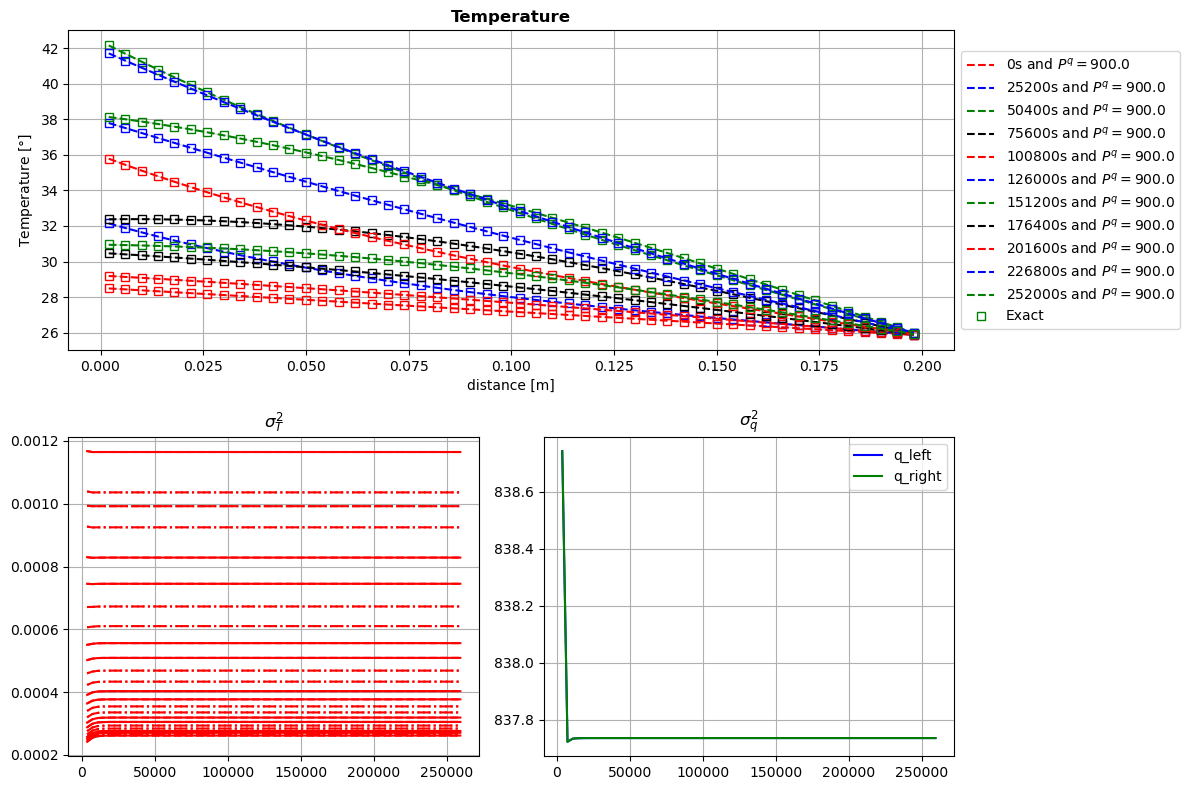

In [95]:
T_first_column_matrix = xs[:,0,0]
HF_last_column_matrix = xs[:,-2,0]
HF_last_column_matrix2 = xs[:,-1,0]
HF_pred_last_column_matrix = xs_pred[:,-2,0]
HF_pred_last_column_matrix2 = xs_pred[:,-1,0]
#print(HF_last_column_matrix)
#print(HF_pred_last_column_matrix)

#pos     = np.array([0, 0.002, 0.006, 0.010, 0.014, 0.018, 0.020])
pos=np.zeros(N+2)# x coordinates
pos[0]=0
pos[-1]=L
for i in range(N):
     pos[i+1]= i*dx+dx/2

print(pos[1:-1])
print(xs.shape)
#print(T_stack[0,:])

time_index = np.arange(0, (m-1)//mean_step,time_intervel//mean_step)

line_styles = ['--', '-.', ':', '-']
line_style = np.array([line_styles[i % len(line_styles)] for i in range(N)])

line_colors = ['r','b','g','k','y','c','m']
line_color=np.array([line_colors[i % len(line_styles)] for i in range(N)])
#real_time = (time_index+1) * dt

#print(xs[10,:-1,0])
#print(T_stack.shape)
#print(cov)

# Create a figure and subplots
fig = plt.figure(figsize=(12, 8))


# Subplot 1 (2x1 grid)
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)  # extends across two columns
for i in range(len(time_index)):
    label_Exact = f"Exact" if i == len(time_index)-1 else None
    std_top = xs[time_index[i],:-2,0] + std[i, :-2]
    std_btm = xs[time_index[i],:-2,0] - std[i, :-2]
    ax1.plot(pos[1:-1], xs[time_index[i],:-2,0], linestyle='--', color = line_color[i],label=f"{(time_index[i])*dt}s and $P^q = {diagonal_elements[-1]}$")
    #plt.plot(pos[1:], xs_pred[time_index[i],:,0], linestyle='', marker='^', color = line_color[i],label=f"{(time_index[i])*dt}s and $P^q = {diagonal_elements[-1]}$")
    ax1.plot(pos[1:-1], T_stack[time_index[i]*mean_step,:], linestyle='', marker='s', color = line_color[i],fillstyle='none',label=label_Exact)
    ax1.fill_between(pos[1:-1], std_top, std_btm,
                   facecolor='k', alpha=0.2, interpolate=True)


#print(xs[time_index[i],:-2,0].shape,std[i, :-2].shape)
ax1.set_title('Temperature', fontweight='bold')
plt.xlabel('distance [m]')
plt.ylabel(r'Temperature [$\degree$]')
#plt.legend()
plt.legend(fontsize=10,loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)

# Subplot 2 (2x1 grid)
ax2 = plt.subplot2grid((2, 2), (1, 0))  # first column
for i in range(len(diagonal_elements)-2):
    ax2.plot(time, var[:,i], color = 'red', alpha = 1, linestyle = line_style[i-1], label=f"${i}$")
#plt.gca().get_lines()[0].set_visible(False) #hide specified lines
    
ax2.set_title(r'$\sigma_{T}^2$',fontweight='bold')
#plt.legend()
plt.grid(True)

# Subplot 3 (2x1 grid)
ax3 = plt.subplot2grid((2, 2), (1, 1))  # second column
ax3.plot(time, var[:,-2], color='b',label='q_left')
ax3.plot(time, var[:,-1], color='g',label='q_right')
ax3.set_title(r'$\sigma_{q}^2$',fontweight='bold')

plt.legend()

# Adjust layout
plt.tight_layout()

plt.grid(True)


# Set new limits for the x and y axes
#plt.xlim([0, 0.02])  # Set x-axis limits from 0 to 0.02
#plt.ylim([0, 300])   # Set y-axis limits from 0 to 200


print(var[0,:])
#save_path = '/Users/minghan/OneDrive - Cornell University/JupyterNotes/Data_Assimilation/HeatFluxInference_KF/Results/AugmentedState/KF_insulated/Temp_var_Q=0_P=0.png'
#plt.savefig(save_path,format='png', dpi=300, bbox_inches='tight')

detailed investigation of covariance and kalman filter

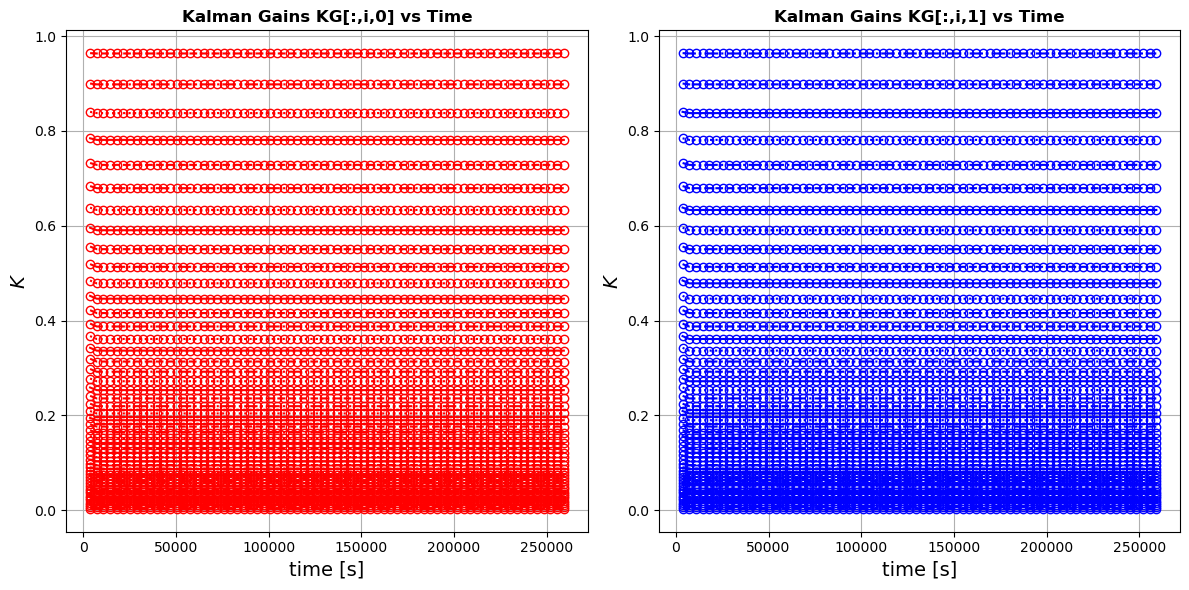

238.61284029556015 38


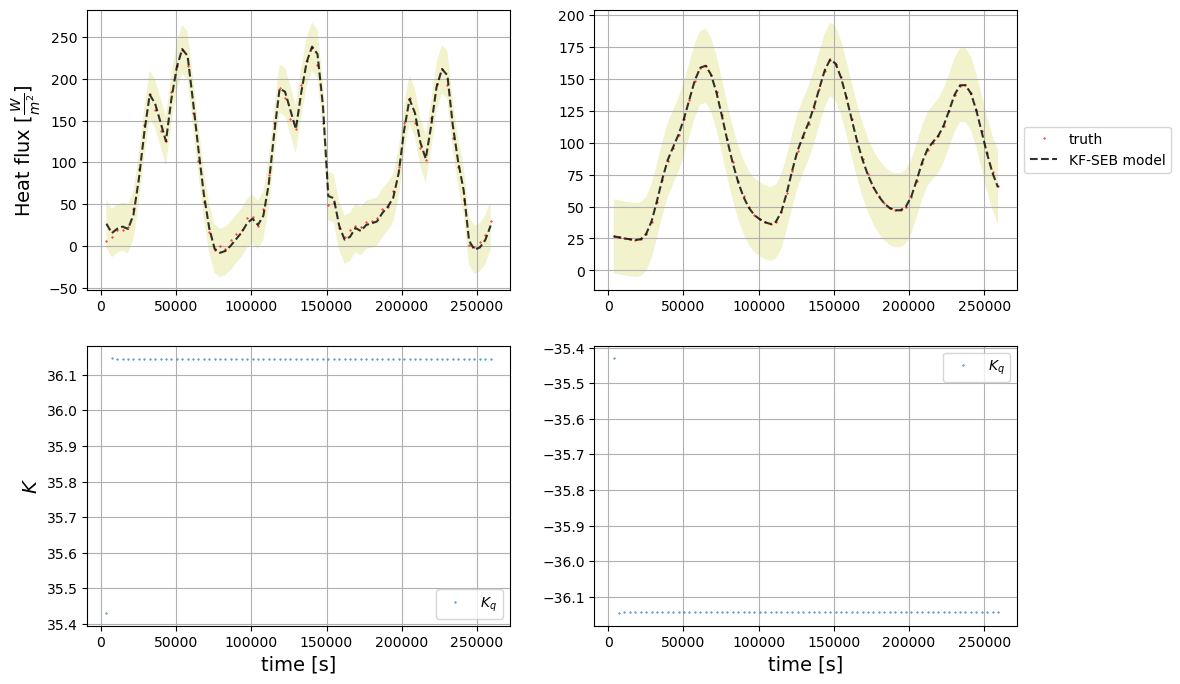

In [96]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

for i in range(len(diagonal_elements) - 2):
    # 左侧子图
    axs[0].plot(time, KG[:, i, 0], marker='o', fillstyle='none', color='red', alpha=1, linestyle=line_style[i % len(line_style)], label=f"${i}$")
    # 右侧子图
    axs[1].plot(time, KG[:, i, 1], marker='o', fillstyle='none', color='blue', alpha=1, linestyle=line_style[i % len(line_style)], label=f"${i}$")

# 设置左侧子图标题、标签和网格
axs[0].set_title(r'Kalman Gains KG[:,i,0] vs Time', fontweight='bold')
axs[0].set_xlabel('time [s]', fontsize=14)
axs[0].set_ylabel(r'$K$', fontsize=14)
axs[0].grid(True)

# 设置右侧子图标题、标签和网格
axs[1].set_title(r'Kalman Gains KG[:,i,1] vs Time', fontweight='bold')
axs[1].set_xlabel('time [s]', fontsize=14)
axs[1].set_ylabel(r'$K$', fontsize=14)
axs[1].grid(True)

# 调整子图布局
plt.tight_layout()
plt.show()

#save_path = '/Users/minghan/OneDrive - Cornell University/JupyterNotes/Data_Assimilation/HeatFluxInference_KF/Results/AugmentedState/KF_insulated/KG.png'
#plt.savefig(save_path,format='png', dpi=300, bbox_inches='tight')

string_list = ["R = 0.01", "R = 0.1", "R = 1", "R = 10", "R = 100"]
transparent = [1, 0.8, 0.3, 0.5, 0.7, 0.9]

array_ones = np.ones((num_iterations, 1))
#hf = array_ones * 0 #exact heat flux
#hf=flux_magnitude*np.sin(flux_frequency*np.array(time))
#hf1=-k*(T_stack[:,0]-T_left[:])/(0.5*dx)
hf1=G_ground_true
hf2=k*(T_stack[:,-1]-T_right)/(0.5*dx)
hf2=-k*(T_stack[:,-1]-T_stack[:,-2])/(1*dx)
#print(hf2[0:10],T_stack[0:10,-1],T_right[0:10])

hf1_2=np.zeros(len(hf1)//mean_step)
hf2_2=np.zeros(len(hf2)//mean_step)
for i in range(len(hf1_2)):
    start_index = i * mean_step
    end_index = start_index + mean_step
    hf1_2[i] = np.mean(hf1[start_index:end_index])
    hf2_2[i] = np.mean(hf2[start_index:end_index])


std_top  = HF_last_column_matrix[:] + std[:, -2]
std_btm  = HF_last_column_matrix[:] - std[:, -2]

std_top2  = HF_last_column_matrix2[:] + std[:, -1]
std_btm2  = HF_last_column_matrix2[:] - std[:, -1]
#print(std[:,-1])

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0,0].plot(time, hf1_2, color = 'r', linestyle='', marker='o', fillstyle='none',markersize=0.5,label=f"truth")

axs[0,0].plot(time, HF_last_column_matrix,'--',color = 'k', label=f"z_variance: {R_var1} \nQ_HF = {Q[-1,-1]} \nP_HF = {P_init[-1]}", alpha = transparent[1])
#plt.plot(time, HF_pred_last_column_matrix,linestyle='--', color = 'k', markerfacecolor='none', label=f"z_variance: {R_var} \nQ_HF = {Q[-1,-1]} \nP_HF = {P_init[-1]}", alpha = transparent[1])

axs[0,0].fill_between(time, std_top, std_btm,
                     facecolor='y', alpha=0.2, interpolate=True)

#axs[0].set_xlabel('time [s]',fontsize=14)
axs[0,0].set_ylabel(r'Heat flux [$\frac{W}{m^2}$]',fontsize=14)

#axs[0].set_ylim([-20, 20])   # Set y-axis limits from 0 to 200
#axs[0,0].legend(fontsize=10,loc='center left', bbox_to_anchor=(1, 0.5))
axs[0,0].grid(True)

axs[1,0].plot(time,KG[:,-2,0],linestyle='', marker='o', label=r'$K_{q}$', fillstyle='none', markersize=0.5)
axs[1,0].set_xlabel('time [s]',fontsize=14)
axs[1,0].set_ylabel(r'$K$',fontsize=14)
axs[1,0].legend(fontsize=10)
axs[1,0].grid(True)



axs[0,1].plot(time, hf2_2, color = 'r', linestyle='', marker='o', fillstyle='none',markersize=0.5,label=f"truth")

axs[0,1].plot(time, HF_last_column_matrix2,'--',color = 'k', label="KF-SEB model", alpha = transparent[1])
#plt.plot(time, HF_pred_last_column_matrix,linestyle='--', color = 'k', markerfacecolor='none', label=f"z_variance: {R_var} \nQ_HF = {Q[-1,-1]} \nP_HF = {P_init[-1]}", alpha = transparent[1])

axs[0,1].fill_between(time, std_top2, std_btm2,
                     facecolor='y', alpha=0.2, interpolate=True)

#axs[0].set_xlabel('time [s]',fontsize=14)
#axs[0,0].set_ylabel(r'Heat flux [$\frac{W}{m^2}$]',fontsize=14)

#axs[0].set_ylim([-20, 20])   # Set y-axis limits from 0 to 200
axs[0,1].legend(fontsize=10,loc='center left', bbox_to_anchor=(1, 0.5))
axs[0,1].grid(True)

axs[1,1].plot(time,KG[:,-1,1],linestyle='', marker='o', label=r'$K_{q}$', fillstyle='none', markersize=0.5)
axs[1,1].set_xlabel('time [s]',fontsize=14)
#axs[1,1].set_ylabel(r'$K$',fontsize=14)
axs[1,1].legend(fontsize=10)
axs[1,1].grid(True)

print(np.max(HF_last_column_matrix),np.argmax(HF_last_column_matrix))
#save_path = f'/Users/minghan/OneDrive - Cornell University/JupyterNotes/Data_Assimilation/HeatFluxInference_KF/Results/AugmentedState/KF_insulated/HF_P00({diagonal_elements[0]})_P66({diagonal_elements[-1]})_zvar({R_var}).png'
#plt.savefig(save_path,format='png', dpi=300, bbox_inches='tight')

(72,) (72,) (72,) (72,) (72,)
(72,) (72,) (72,) (72,) (72,)
7.575372677170241 81.44226199624224


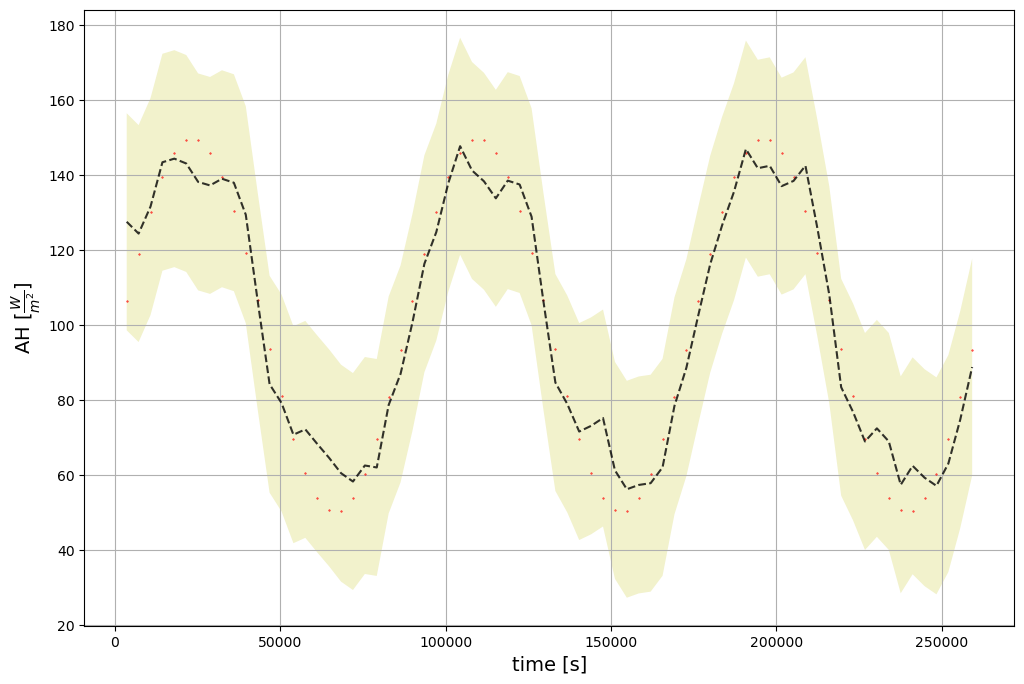

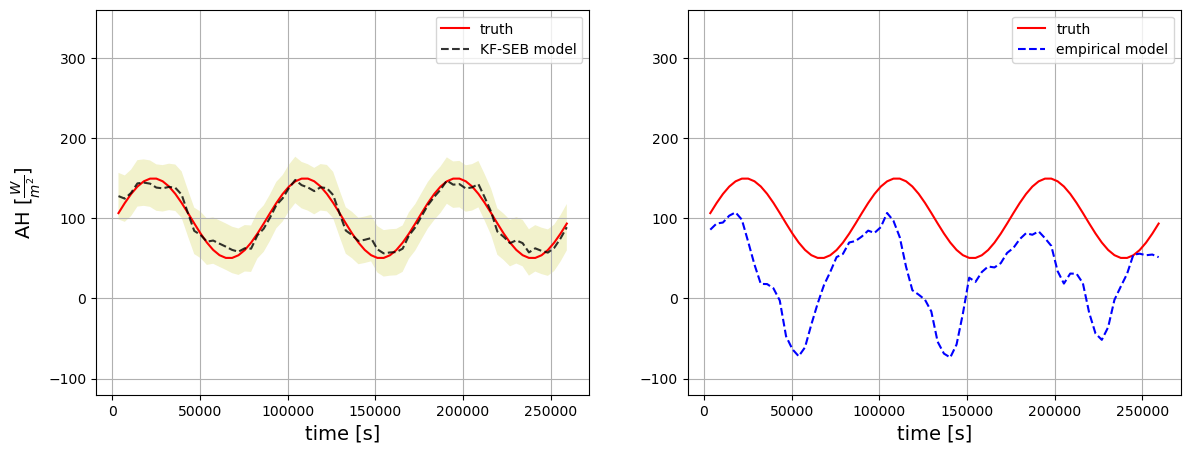

In [97]:
# Create subplots
#for i in range(0,num_iterations,1):
    #H_sensible[i]=rho_air*cp_air*(zs1[i]-T_can[i])/r_a1
    #H_sensible[i]=rho_air*cp_air*(T_left[i]-T_can[i])/r_a1

fig, axs = plt.subplots(1, 1, figsize=(12, 8))
print(AH_true.shape, HF_last_column_matrix.shape, H_sensible.shape, R_n.shape, (HF_last_column_matrix+H_sensible-R_n).shape)
axs.plot(time, AH_true, color = 'r', linestyle='', marker='o', fillstyle='none',markersize=0.5,label=f"truth")

axs.plot(time, HF_last_column_matrix+H_sensible-R_n[0:int(Time/dt)].reshape(int(Time/dt)),'--',color = 'k', label=f"z_variance: {R_var1} \nQ_HF = {Q[-1,-1]} \nP_HF = {P_init[-1]}", alpha = transparent[1])
#plt.plot(time, HF_pred_last_column_matrix,linestyle='--', color = 'k', markerfacecolor='none', label=f"z_variance: {R_var} \nQ_HF = {Q[-1,-1]} \nP_HF = {P_init[-1]}", alpha = transparent[1])

axs.fill_between(time, std_top+H_sensible-R_n[0:int(Time/dt)].reshape(int(Time/dt)), std_btm+H_sensible-R_n[0:int(Time/dt)].reshape(int(Time/dt)),
                     facecolor='y', alpha=0.2, interpolate=True)

axs.set_xlabel('time [s]',fontsize=14)
axs.set_ylabel(r'AH [$\frac{W}{m^2}$]',fontsize=14)

#axs[0].set_ylim([-20, 20])   # Set y-axis limits from 0 to 200
#axs[0,0].legend(fontsize=10,loc='center left', bbox_to_anchor=(1, 0.5))
axs.grid(True)




Cg=0.4

G_empirical=Cg*R_n

uncertainty_empirical=np.zeros(len(T_left))
#for i in range(len(T_left)):
    #uncertainty_empirical[i]=math.sqrt(R_var1)*(rho_air*cp_air/r_a1+4*e*sigma*(1+Cg)*T_left[i]**3)


# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
print(AH_true.shape, HF_last_column_matrix.shape, H_sensible.shape, R_n.shape, (HF_last_column_matrix+H_sensible-R_n).shape)
axs[0].plot(time, AH_true, color = 'r', linestyle='-', fillstyle='none',markersize=0.5,label=f"truth")

axs[0].plot(time, HF_last_column_matrix+H_sensible-R_n[0:int(Time/dt)].reshape(int(Time/dt)),'--',color = 'k', label="KF-SEB model", alpha = transparent[1])

#plt.plot(time, HF_pred_last_column_matrix,linestyle='--', color = 'k', markerfacecolor='none', label=f"z_variance: {R_var} \nQ_HF = {Q[-1,-1]} \nP_HF = {P_init[-1]}", alpha = transparent[1])

axs[0].fill_between(time, std_top+H_sensible-R_n[0:int(Time/dt)].reshape(int(Time/dt)), std_btm+H_sensible-R_n[0:int(Time/dt)].reshape(int(Time/dt)),
                     facecolor='y', alpha=0.2, interpolate=True)

axs[0].set_xlabel('time [s]',fontsize=14)
axs[0].set_ylabel(r'AH [$\frac{W}{m^2}$]',fontsize=14)

axs[0].set_ylim([-120, 360])   # Set y-axis limits from 0 to 200
#axs[0,0].legend(fontsize=10,loc='center left', bbox_to_anchor=(1, 0.5))
axs[0].legend(fontsize=10)
axs[0].grid(True)

axs[1].plot(time, AH_true, color = 'r', linestyle='-', fillstyle='none',markersize=0.5,label=f"truth")
axs[1].plot(time, G_empirical+H_sensible-R_n[0:int(Time/dt)].reshape(int(Time/dt)),'--',color = 'blue',label="empirical model")
axs[1].fill_between(time, G_empirical+uncertainty_empirical+H_sensible-R_n[0:int(Time/dt)].reshape(int(Time/dt)), G_empirical-uncertainty_empirical+H_sensible-R_n[0:int(Time/dt)].reshape(int(Time/dt)),
                     facecolor='y', alpha=0.2, interpolate=True)
axs[1].set_xlabel('time [s]',fontsize=14)
axs[1].set_ylim([-120, 360])
axs[1].legend(fontsize=10)
axs[1].grid(True)


# 计算RMSE
rmse1 = np.sqrt(
    np.mean(
        (HF_last_column_matrix[int(len(HF_last_column_matrix)/3):] + 
         H_sensible[int(len(H_sensible)/3):] - 
         R_n[int(len(R_n)/3):int(Time/dt)] - 
         AH_true[int(len(AH_true)/3):]) ** 2
    )
)

rmse2 = np.sqrt(
    np.mean(
        (G_empirical[int(len(G_empirical)/3):] + 
         H_sensible[int(len(H_sensible)/3):] - 
         R_n[int(len(R_n)/3):int(Time/dt)] - 
         AH_true[int(len(AH_true)/3):]) ** 2
    )
)
print(rmse1,rmse2)

In [98]:

np.savez('KF_SEB_UCM_09_sin_sigma1_skip60_250520.npz', T_left=T_left, T_right=T_right, G_ground_true=G_ground_true, AH_true=AH_true, H_sensible_true=H_sensible, R_n=R_n,
        G_ground=G_ground, AH=AH, H_sensible=H_sensible, T_KF=xs[:,:-2,0], G_KF=HF_last_column_matrix, var_G=var[:,-2],AH_KF=HF_last_column_matrix+H_sensible-R_n[0:int(Time/dt)].reshape(int(Time/dt)),
        AH_KF_top=std_top+H_sensible-R_n[0:int(Time/dt)].reshape(int(Time/dt)), AH_KF_btm=std_btm+H_sensible-R_n[0:int(Time/dt)].reshape(int(Time/dt)), G_empirical=G_empirical,
        time=time, pos=pos[1:-1], time_index=time_index, var=var, std=std, T_stack=T_stack,mean_step=mean_step,line_color=line_color,dt=dt,
        G_KF_top=HF_last_column_matrix[:] + std[:, -2],
        G_KF_btm=HF_last_column_matrix[:] - std[:, -2],
        H_sensible_top=H_sensible,H_sensible_btm=H_sensible,
        rmse_KF=rmse1, rmse_empirical=rmse2)

